In [14]:
import yfinance as yf
import pandas_datareader.data as web
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

yf.pdr_override()

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

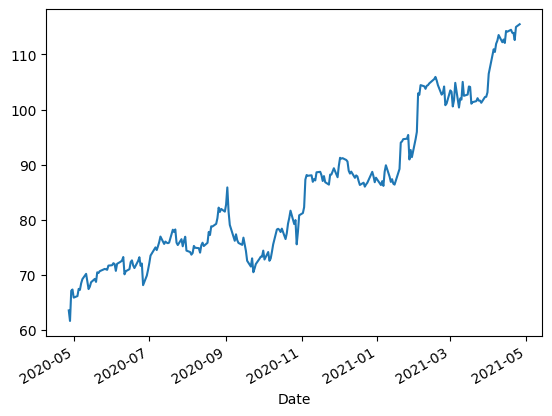

In [6]:
ser_google = web.get_data_yahoo(tickers='GOOGL', start='2020-04-27', end='2021-04-27')['Close']
ser_google.plot()

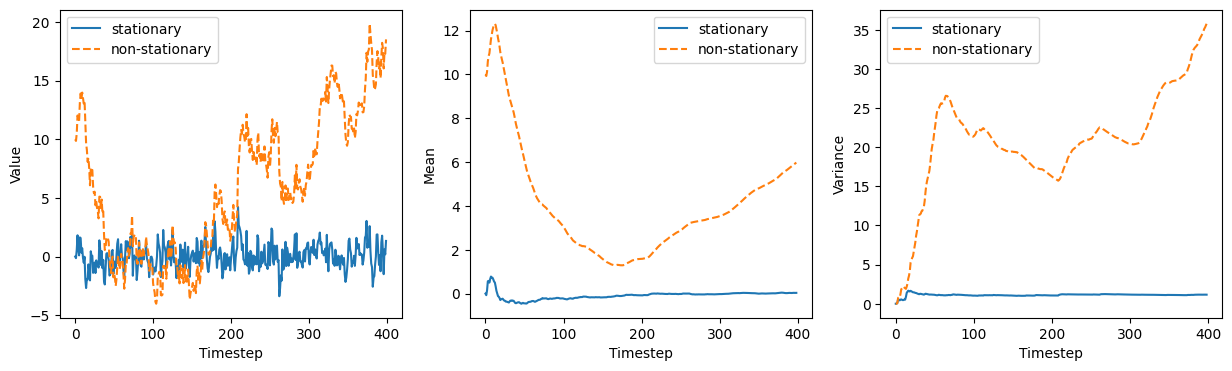

In [7]:
stationary = np.empty(400)
stationary[0] = 0
non_stationary = np.empty(400)
non_stationary[0] = 10
np.random.seed(42)
steps = np.random.standard_normal(400)

for i in range(1, 400):
    stationary[i] = 0.5 * stationary[i-1] + steps[i]
    non_stationary[i] = non_stationary[i-1] + steps[i]

mean_stationary = [stationary[:i].mean() for i in range(1, 400)]
mean_non_stationary = [non_stationary[:i].mean() for i in range(1, 400)]

var_stationary = [stationary[:i].var() for i in range(1, 400)]
var_non_stationary = [non_stationary[:i].var() for i in range(1, 400)]

fig, axes = plt.subplots(1, 3, figsize=[15, 4])

axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('Value')
axes[0].plot(stationary, label='stationary')
axes[0].plot(non_stationary, label='non-stationary', ls='dashed')
axes[0].legend()

axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('Mean')
axes[1].plot(mean_stationary, label='stationary')
axes[1].plot(mean_non_stationary, label='non-stationary', ls='dashed')
axes[1].legend()

axes[2].set_xlabel('Timestep')
axes[2].set_ylabel('Variance')
axes[2].plot(var_stationary, label='stationary')
axes[2].plot(var_non_stationary, label='non-stationary', ls='dashed')
axes[2].legend()

ADF Statics: -0.966
p-value: 0.765


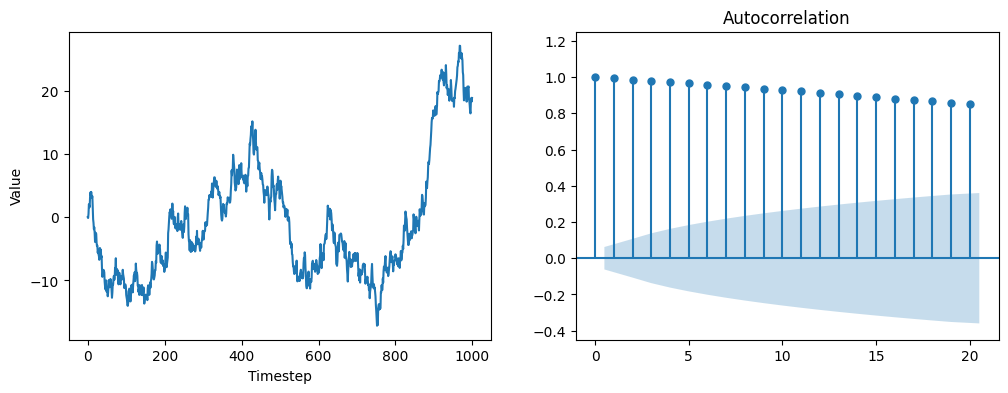

In [8]:
np.random.seed(42)
steps = np.random.standard_normal(1000)
steps[0] = 0
random_walk = steps.cumsum()

ADF_result = adfuller(random_walk)
print(f'ADF Statics: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')

fig, axes = plt.subplots(1, 2, figsize=[12, 4])
axes[0].plot(random_walk)
axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('Value')
plot_acf(random_walk, ax=axes[1], lags=20, auto_ylims=True)
plt.show()

ADF Statics: -31.789
p-value: 0.000


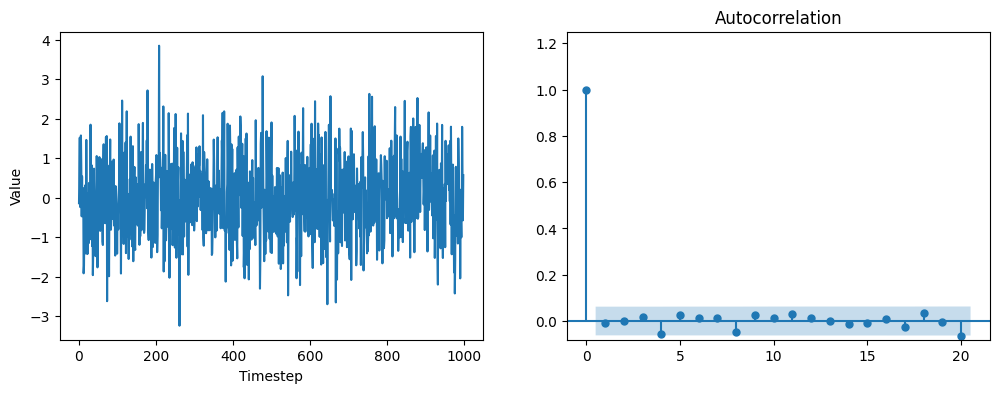

In [9]:
diff_random_walk = np.diff(random_walk)
ADF_result = adfuller(diff_random_walk)
print(f'ADF Statics: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')

fig, axes = plt.subplots(1, 2, figsize=[12, 4])
axes[0].plot(diff_random_walk)
axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('Value')
plot_acf(diff_random_walk, ax=axes[1], lags=20, auto_ylims=True)
plt.show()

In [10]:
ADF_google_result = adfuller(ser_google)
print(f'ADF Statics: {ADF_google_result[0]:.3f}')
print(f'p-value: {ADF_google_result[1]:.3f}')

ADF Statics: 0.318
p-value: 0.978


ADF Statics: -5.263
p-value: 0.000


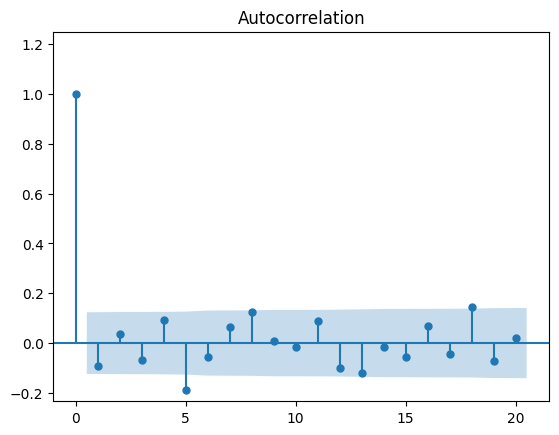

In [11]:
ser_google_diff = ser_google.diff().dropna()
ADF_google_result = adfuller(ser_google_diff)
print(f'ADF Statics: {ADF_google_result[0]:.3f}')
print(f'p-value: {ADF_google_result[1]:.3f}')

plot_acf(ser_google_diff, lags=20, auto_ylims=True)
plt.show()

In [15]:
df = pd.DataFrame({'value': random_walk})
train = df[:800]
test = df[800:]

/tmp/ipykernel_13890/1854262779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_mean'] = train.mean().value
/tmp/ipykernel_13890/1854262779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last'] = train.iloc[-1].value
/tmp/ipykernel_13890/1854262779.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

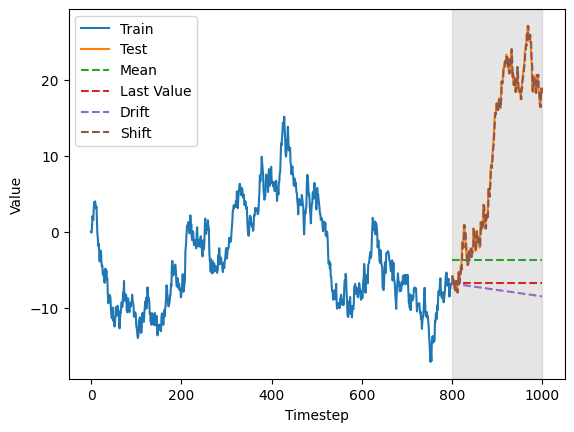

In [16]:
test.loc[:, 'pred_mean'] = train.mean().value
test.loc[:, 'pred_last'] = train.iloc[-1].value
drift = (train['value'].iloc[-1] - train['value'].iloc[0]) / (train.index[-1] - train.index[0])
test.loc[:, 'pred_drift'] = np.arange(801, 1001) * drift
test.loc[:, 'pred_shift'] = df['value'].shift()[800:]

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.plot(train.index, train['value'], label='Train')
plt.plot(test.index, test['value'], label='Test')
plt.plot(test.index, test['pred_mean'], ls='dashed', label='Mean')
plt.plot(test.index, test['pred_last'], ls='dashed', label='Last Value')
plt.plot(test.index, test['pred_drift'], ls='dashed', label='Drift')
plt.plot(test.index, test['pred_shift'], ls='dashed', label='Shift')
plt.axvspan(test.index[0], test.index[-1], alpha=0.2, color='gray')

plt.legend()

Text(0, 0.5, 'MSE')

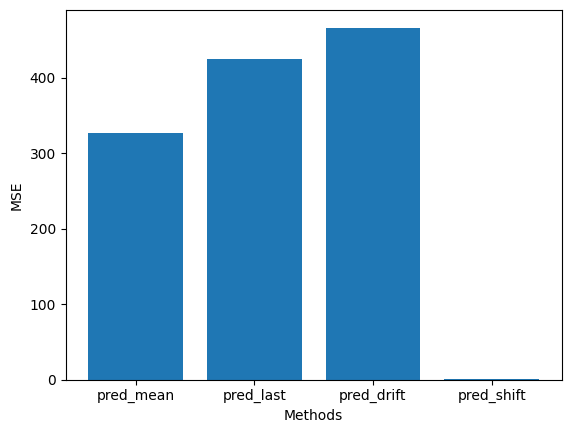

In [17]:
xs = ['pred_mean', 'pred_last', 'pred_drift', 'pred_shift']
ys = [mean_squared_error(test['value'], test[x]) for x in xs]

plt.bar(xs, ys)
plt.xlabel('Methods')
plt.ylabel('MSE')